# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from re import VERBOSE

2024-03-11 16:42:50.217354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 16:42:50.217467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 16:42:50.327183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
x_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]

In [4]:
print(x_train.shape)
print(y_train.shape)

(42000, 784)
(42000,)


In [5]:
x_train_np = x_train.to_numpy()
x_train_reshaped = x_train_np.reshape(-1, 28, 28)

(42000, 28, 28)

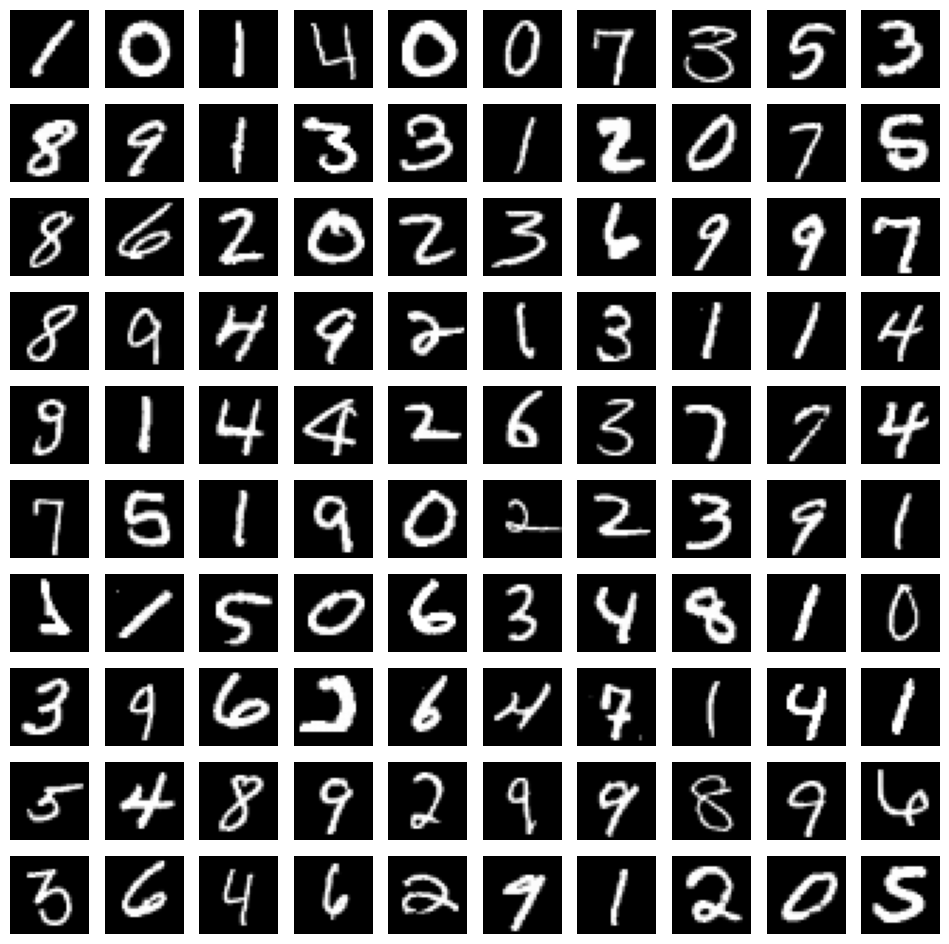

In [8]:
plt.figure(figsize = (12,12))
for i in range(100):
 plt.subplot(10,10,i+1)
 plt.axis('off')
 plt.imshow(x_train_reshaped[i], cmap = 'gray')

In [7]:
x_train_np = x_train_np.reshape([42000,28,28,1])
x_train_np.shape

(42000, 28, 28, 1)

In [8]:
y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [9]:
# Make the y_train one-hot encoded
y_train = to_categorical(y_train, num_classes = 10)

In [10]:
print(x_train.shape)
print(y_train.shape)

(42000, 784)
(42000, 10)


In [11]:
# Split the training data into train and val datasets
x_train_np, x_val_np, y_train, y_val = train_test_split(x_train_np, y_train, test_size=0.2, random_state=42)

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 15,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2
)

train_datagen.fit(x_train_np)
train_generator = train_datagen.flow(x_train_np, y_train, batch_size=512)

In [13]:
val_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen.fit(x_val_np)
val_generator = val_datagen.flow(x_val_np, y_val, batch_size=128, shuffle=False)

# Model

In [14]:
leakyRelu = tf.keras.layers.LeakyReLU(alpha=0.1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation=leakyRelu, input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation=leakyRelu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation=leakyRelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation=leakyRelu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=leakyRelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,042 (5.02 MB)

 Trainable params: 1,314,634 (5.01 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Test Optimizers

Tested mulitple optimizers to find the best one.\
Adam performed the best.

Optimizer: Adam, Metrics: {'Best Validation Accuracy': 0.9936904907226562, 'Epochs Run': 16}\
Optimizer: SGD, Metrics: {'Best Validation Accuracy': 0.9907143115997314, 'Epochs Run': 50}\
Optimizer: RMSprop, Metrics: {'Best Validation Accuracy': 0.9917857050895691, 'Epochs Run': 13}\
Optimizer: Adagrad, Metrics: {'Best Validation Accuracy': 0.9760714173316956, 'Epochs Run': 50}

In [41]:
# from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

# optimizers = {
#     'Adam': Adam(),
#     'SGD': SGD(),
#     'RMSprop': RMSprop(),
#     'Adagrad': Adagrad(),
# }

# def createModel():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Dropout(0.3),

#         tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(2, 2),
#         tf.keras.layers.Dropout(0.4),

#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(10, activation='softmax')
#     ])
#     return model

# results = {}

In [42]:
# for name, optimizer in optimizers.items():
#     # Create a new model instance
#     model = createModel()
    
#     # Compile model with the current optimizer
#     model.compile(optimizer=optimizer,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     # Fit the model (assume train_generator and val_generator are already defined)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#     history = model.fit(
#         train_generator,
#         validation_data=val_generator,
#         epochs=50,
#         verbose=1,
#         callbacks=[early_stopping]
#     )
    
#     # Record the best validation accuracy
#     best_val_acc = max(history.history['val_accuracy'])
    
#     # Optionally, record more metrics or details
#     results[name] = {
#         'Best Validation Accuracy': best_val_acc,
#         'Epochs Run': len(history.history['val_accuracy']),
#         # Add more metrics or details if desired
#     }

# # Print or analyze the results
# for optimizer, metrics in results.items():
#     print(f"Optimizer: {optimizer}, Metrics: {metrics}")

In [16]:
optimizer = Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
def adjust_batch_size(epoch, initial_batch_size=16, adjustment_strategy=None, max_batch_size=512):
    # Example strategy: double the batch size after every 4 epochs
    if adjustment_strategy == 'double_every_4':
        factor = epoch // 4
        new_batch_size = initial_batch_size * (2 ** factor)
    else:
        return initial_batch_size

    # Ensure the batch size does not exceed the maximum limit
    return min(new_batch_size, max_batch_size)

In [18]:
class LearningRateReducer(keras.callbacks.Callback):
    def __init__(self, factor=0.1, patience=3, min_lr=0):
        super(LearningRateReducer, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr

    def on_epoch_end(self, epoch, logs=None):
        old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        new_lr = max(old_lr * self.factor, self.min_lr)
        self.model.optimizer.learning_rate.assign(new_lr)

In [19]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_val_loss = float('inf')  # Initialize the best validation loss to infinity
patience = 5  # Number of epochs to wait after val loss has stopped improving
patience_counter = 0  # Counter for how many epochs we have waited

epochs = 65
initial_batch_size = 16

learning_rate_reducer = LearningRateReducer(factor=0.95, patience=2, min_lr=0.00001)

for epoch in range(epochs):
    batch_size = adjust_batch_size(epoch, initial_batch_size, 'double_every_4')
    
    # Recreate the train_generator with the new batch size
    train_generator = train_datagen.flow(x_train_np, y_train, batch_size=batch_size)
    
    # Perform training for the epoch
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,  # We are manually looping over epochs, so fit for 1 epoch at a time
        verbose=1,
        callbacks=[learning_rate_reducer]
    )
    
    # Get the current epoch's validation loss
    current_val_loss = history.history['val_loss'][0]
    
    # Check if the current validation loss is the best we've seen so far
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Save the model weights
        weights = model.get_weights()
    else:
        patience_counter += 1  # Increment the patience counter
    
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    train_accuracies.append(history.history['accuracy'][0])
    val_accuracies.append(history.history['val_accuracy'][0])
    
    current_lr = model.optimizer.learning_rate.numpy()
    print(f"Epoch {epoch + 1}: Learning Rate = {round(current_lr,5)}")
    
    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        # Restore the best model weights
        # Restore the model's weights
        model.set_weights(weights)
        break  # Exit the training loop

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  20/2100 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.0999 - loss: 3.8069  

I0000 00:00:1710175624.095493     159 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710175624.117021     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.5962 - loss: 1.4313 - val_accuracy: 0.9780 - val_loss: 0.0684
Epoch 1: Learning Rate = 0.0009500000160187483
   1/2100 ━━━━━━━━━━━━━━━━━━━━ 2:35 74ms/step - accuracy: 0.9375 - loss: 0.3333

W0000 00:00:1710175643.107111     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8952 - loss: 0.3370 - val_accuracy: 0.9804 - val_loss: 0.0616
Epoch 2: Learning Rate = 0.0008999999845400453
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9285 - loss: 0.2326 - val_accuracy: 0.9848 - val_loss: 0.0518
Epoch 3: Learning Rate = 0.000859999970998615
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9434 - loss: 0.1977 - val_accuracy: 0.9892 - val_loss: 0.0321
Epoch 4: Learning Rate = 0.0008099999977275729
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9645 - loss: 0.1173 - val_accuracy: 0.9896 - val_loss: 0.0324
Epoch 5: Learning Rate = 0.0007699999841861427
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9686 - loss: 0.1067 - val_accuracy: 0.9915 - val_loss: 0.0284
Epoch 6: Learning Rate = 0.0007399999885819852
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9690 - loss: 0.0975 - val_accuracy: 0.9905 - val_loss: 0.0275
Epoch 7: Learning Rate = 0.0006999999750405

W0000 00:00:1710175769.701617     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


525/525 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9761 - loss: 0.0803 - val_accuracy: 0.9939 - val_loss: 0.0191
Epoch 9: Learning Rate = 0.0006300000241026282
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9808 - loss: 0.0627 - val_accuracy: 0.9936 - val_loss: 0.0195
Epoch 10: Learning Rate = 0.0006000000284984708
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9796 - loss: 0.0652 - val_accuracy: 0.9925 - val_loss: 0.0224
Epoch 11: Learning Rate = 0.0005699999746866524
525/525 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9818 - loss: 0.0586 - val_accuracy: 0.9924 - val_loss: 0.0251
Epoch 12: Learning Rate = 0.000539999979082495
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9827 - loss: 0.0527 - val_accuracy: 0.9937 - val_loss: 0.0172
Epoch 13: Learning Rate = 0.0005099999834783375
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9849 - loss: 0.0496 - val_accuracy: 0.9940 - val_loss: 0.0171
Epoch 14: Learning Rate = 0.0004900000058114529


W0000 00:00:1710175955.050608     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - accuracy: 0.9890 - loss: 0.0388 - val_accuracy: 0.9948 - val_loss: 0.0160
Epoch 21: Learning Rate = 0.00033999999868683517
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.9869 - loss: 0.0436 - val_accuracy: 0.9948 - val_loss: 0.0168
Epoch 22: Learning Rate = 0.00031999999191612005
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.9890 - loss: 0.0367 - val_accuracy: 0.9944 - val_loss: 0.0154
Epoch 23: Learning Rate = 0.0003100000030826777
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.9900 - loss: 0.0341 - val_accuracy: 0.9946 - val_loss: 0.0159
Epoch 24: Learning Rate = 0.0002899999963119626
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.9882 - loss: 0.0377 - val_accuracy: 0.9946 - val_loss: 0.0153
Epoch 25: Learning Rate = 0.0002800000074785203
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.9883 - loss: 0.0387 - val_accuracy: 0.9943 - val_loss: 0.0158
Epoch 26: Learning Rate = 0.00026000000070780516
6

## Proper training

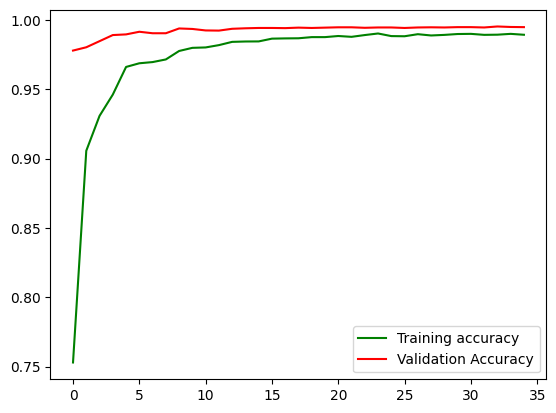

In [21]:
plt.figure()
plt.plot(train_accuracies, color = 'green', label = 'Training accuracy')
plt.plot(val_accuracies, color = 'red', label = 'Validation Accuracy')
plt.legend()

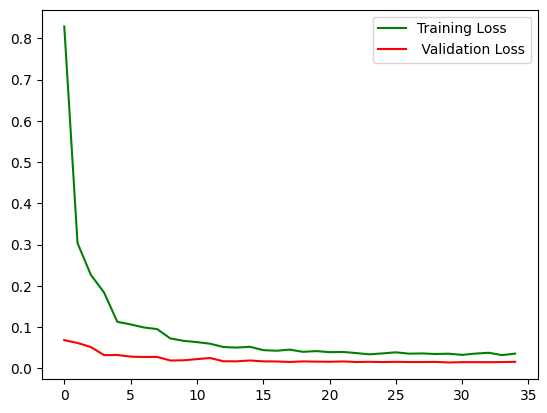

In [22]:
plt.figure()
plt.plot(train_losses, color = 'green', label = 'Training Loss')
plt.plot(val_losses, color = 'red', label = ' Validation Loss')
plt.legend()

# Evaluate

In [23]:
predictions = model.predict(val_generator, steps=len(val_generator))

y_preds = np.argmax(predictions, axis=1)

y_true = np.argmax(y_val, axis=1)

# # Compute the confusion matrix
cm = confusion_matrix(y_true, y_preds)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


W0000 00:00:1710176256.298115     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [24]:
# Accuracy: 0.9904761904761905

accuracy = accuracy_score(y_true, y_preds)
print("Accuracy:", accuracy)

Accuracy: 0.9948809523809524


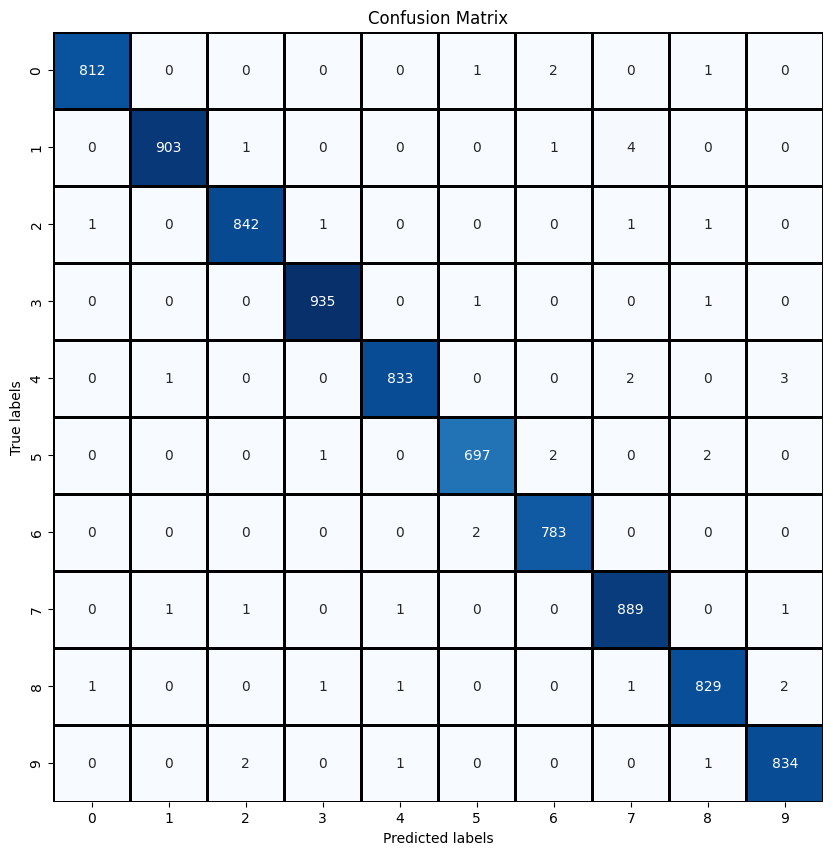

In [25]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, linecolor='black', linewidth=1)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Submission

In [26]:
x_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
x_test_np = x_test.to_numpy()
x_test_np = x_test_np.reshape([28000,28,28,1])

In [27]:
test_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen.fit(x_val_np)
test_generator = test_datagen.flow(x_test_np, batch_size=128, shuffle=False)

In [28]:
test_preds = model.predict(test_generator, steps=len(test_generator))

y_preds = np.argmax(test_preds, axis=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


W0000 00:00:1710176295.698023     160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [29]:
ImageId_list = list(range(1, len(y_preds) + 1))
sub_df = pd.DataFrame({'ImageId': ImageId_list, 'Label': y_preds})

sub_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [30]:
sub_df.to_csv('output.csv', index=False)